In [1]:
# path variables
import sys
project_path = '/Users/naresh/Downloads/DS/growth/nsl_v2/nsl_v2_final/'
sys.path.insert(0, project_path+'config')
from config import SQLQuery

# core libraries
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime
import pandas as pd
import numpy as np
from datetime import date

from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from model_evaluations import model_metrics, cross_validation
from model_building import tune_hyperparameters

from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score, roc_auc_score
from matplotlib import pyplot

In [2]:
%load_ext autoreload
%autoreload 2
from stability_monitoring import *

#### Load data

In [3]:
# north star customers definition
txn_days = 90
txn_credit_amount = 15000

# from_date = date(2022,10,1)
# to_date = date(2023,2,28)

In [4]:
q = SQLQuery('snowflake')

In [16]:
# query to fetch the required data
df_raw_app = q("""with 

TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

BUSINESSES as -- get all business accounts created between Oct 2022 and Feb 2023
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-07-01' and '2023-02-28'
),

ALLOY_PERSONS as -- get all the alloy persons data (max of application_versions_id in case of duplicates)
(
  select * from (
select * ,
       row_number() over (partition by APPLICATION_ID order by APPLICATION_VERSION_ID desc) as rank
from "PROD_DB"."DATA"."ALLOY_EVALUATIONS_PERSONS") 
where rank=1
),

APPLICATIONS as -- get all entries from applications table
(
  select *
  from "PROD_DB"."DATA"."APPLICATIONS"
),

BASE AS -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.amount) as total_credit_amount
    from BUSINESSES b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND """ + str(txn_days) + """
    group by 1,2
)

    select B.business_id, 
    coalesce(total_credit_amount,0) as total_deposit, S.nsl_v2_prob,
    A.*, P.*
    from BUSINESSES B
    left join base
    on B.business_id = base.business_id
    left join APPLICATIONS A
    on B.application_id = A.application_id
    left join ALLOY_PERSONS P
    on B.application_id = P.application_id
    left join prod_db.adhoc.nsl_v2_model_scores S
    on B.application_id = S.application_id
    """)

df_raw_app.shape

(153396, 167)

In [17]:
# drop null application ids
df_raw_app = df_raw_app.dropna(subset='application_id')

# tag north star customers
df_raw_app['ns_flag'] = np.where(df_raw_app['total_deposit']>=txn_credit_amount, 1, 0)

# get non-ns vs ns accounts split
df_raw_app['ns_flag'].value_counts(dropna=False)

0    138372
1      9917
Name: ns_flag, dtype: int64

In [18]:
# drop duplicate columns
df_raw_app = df_raw_app.loc[:,~df_raw_app.columns.duplicated()].copy()
df_raw_app.shape

(148289, 167)

In [19]:
print('Applications with $0 deposit:', df_raw_app[df_raw_app['total_deposit'] == 0].shape[0])
print('Applications with deposit less than 5K :', df_raw_app[(df_raw_app['total_deposit'] <= 5000)].shape[0])
print('Applications with $15K deposit or more:', df_raw_app[df_raw_app['total_deposit'] >= txn_credit_amount].shape[0])
print('Applications with deposit between $0 and $15K :', df_raw_app[(df_raw_app['total_deposit'] > 0) & (df_raw_app['total_deposit'] < txn_credit_amount)].shape[0])


Applications with $0 deposit: 49797
Applications with deposit less than 5K : 125659
Applications with $15K deposit or more: 9917
Applications with deposit between $0 and $15K : 88575


In [36]:
# raw data
file = 'threshold_decision_app_scoring_dataset.pkl'
path = project_path + 'data/'
# df_raw_app.reset_index(inplace=True)
# df_raw_app.to_pickle(path+file)

# df_raw_app = pd.read_pickle(path+file)

In [37]:
df_raw_app['nsl_v2_prob'] = df_raw_app['nsl_v2_prob'].astype('float')
df_raw_app['proba'] = df_raw_app['nsl_v2_prob']


#### Both SP & Non-SP

In [38]:
df_oot = df_raw_app.copy()

# custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
custom_bins = [0,0.2,0.4,0.6,0.8,1]

df_oot['proba'] = np.round(df_oot['proba'], 3)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats

,ns_flag,volume,volume%
DecileRank,,,
"(0.0, 0.2]",0.013225,65557,0.44
"(0.2, 0.4]",0.043872,42123,0.28
"(0.4, 0.6]",0.110498,23756,0.16
"(0.6, 0.8]",0.239126,13817,0.09
"(0.8, 1.0]",0.427563,2975,0.02


#### Only Non-SP

In [39]:
df_oot = df_raw_app[df_raw_app.business_type!='sole_proprietorship'].copy()
df_oot.reset_index(inplace=True, drop=True)

# custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
custom_bins = [0,0.2,0.4,0.6,0.8,1]

df_oot['proba'] = np.round(df_oot['proba'], 3)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats

,ns_flag,volume,volume%
DecileRank,,,
"(0.0, 0.2]",0.015892,35994,0.36
"(0.2, 0.4]",0.048590,29039,0.29
"(0.4, 0.6]",0.114818,20502,0.20
"(0.6, 0.8]",0.242446,12708,0.13
"(0.8, 1.0]",0.429655,2900,0.03


#### Only SP

In [40]:
df_oot = df_raw_app[df_raw_app.business_type=='sole_proprietorship'].copy()
df_oot.reset_index(inplace=True, drop=True)

# custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
custom_bins = [0,0.2,0.4,0.6,0.8,1]

df_oot['proba'] = np.round(df_oot['proba'], 3)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats

,ns_flag,volume,volume%
DecileRank,,,
"(0.0, 0.2]",0.009979,29563,0.63
"(0.2, 0.4]",0.033400,13084,0.28
"(0.4, 0.6]",0.083282,3254,0.07
"(0.6, 0.8]",0.201082,1109,0.02
"(0.8, 1.0]",0.346667,75,0.00


#### LTV

In [27]:
ltv_df = q("""

WITH
TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

BUSINESSES as -- get all business accounts created between Jul 2020 and Dec 2021
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-07-01' and '2023-02-28'
),

-- APPLICATION_DETAIL as -- get all entries from applications table
-- (
--   select *
--   from "PROD_DB"."DATA"."APPLICATIONS"
-- ),

HDI_MODEL as
(
  select *
  from "PROD_DB"."MODELS"."ONBOARDING_MODEL_RESULTS"
),

NSQL_MODEL as
(
  select *
  from "PROD_DB"."MODELS"."NSQL_SCORING_LATEST"
),

LTV_MODEL as
(
  select *
  from "PROD_DB"."MODELS"."LIFETIME_VALUE_V2_LATEST"
),

BASE as -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.amount) as total_credit_amount
    from BUSINESSES b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 90
    group by 1,2
)    

select businesses.business_id,
       businesses.application_id,
       coalesce(total_credit_amount,0) as total_deposit,
       fraud_score,
       deposit_score,
       pred_prob as nsl_v1_score,
       revenue_ltv
from businesses
left join base
on businesses.application_id = base.application_id
left join hdi_model
on businesses.application_id = hdi_model.application_id
left join nsql_model
on businesses.application_id = nsql_model.application_id
left join ltv_model
on businesses.business_id = ltv_model.business_id

""")

In [106]:
sum(df_oot2.ns_flag)/df_oot2.shape[0]

0.0668761674837648

In [41]:
df_oot2 = pd.merge(df_raw_app.drop(columns=['total_deposit','business_id']), ltv_df, on='application_id', how='left')

In [43]:
df_raw_app.shape, df_oot2.shape

((148289, 169), (148289, 173))

#### Plot Precision vs Recall

In [64]:
def precision_recall_threshold_plot(y_true:np.array, yhat:np.array, thresholds:list):
    # keep probabilities for the positive outcome only
    precision_vals = []
    recall_vals = []
    for threshold in thresholds:
        yhat2 = []
        for val in yhat:
            if val>threshold:
                yhat2.append(1)
            else:
                yhat2.append(0)
        yhat2 = np.array(yhat2)    
        pr = precision_score(y_true, yhat2, average='binary')
        rec = recall_score(y_true, yhat2, average='binary')
        roc_auc = roc_auc_score(y_true, yhat2, average=None)
        
        print('threshold:', threshold, ' predicted:', sum(yhat2), ' pred NS Rate:', np.round(yhat2.mean(),3),
             ' precision:', np.round(pr,3), ' recall:',np.round(rec,3), ' auc:',np.round(roc_auc,3))
        precision_vals.append(pr)
        recall_vals.append(rec)

    plt.figure(figsize=(5,5))
    # plot the roc curve for the model
    pyplot.plot(precision_vals, recall_vals, marker='.')
    # axis labels
    pyplot.xlabel('Precision')
    pyplot.ylabel('Recall')
    pyplot.grid(True)
    pyplot.show()


In [65]:
# Both
df_oot = df_oot2.copy()

custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# custom_bins = [0,0.2,0.4,0.6,0.8,1]

df_oot['proba'] = np.round(df_oot['proba'], 3)
# df_oot['DecileRank']= pd.qcut(df_oot['proba'], q=5)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats['ltv'] = df_oot.groupby(by='DecileRank')['revenue_ltv'].sum()
df_stats['avg_ltv'] = df_stats['ltv'] / df_stats['volume']

df_stats

,ns_flag,volume,volume%,ltv,avg_ltv
DecileRank,,,,,
"(0.0, 0.1]",0.004992,22637,0.15,1.131327e+07,499.768929
"(0.1, 0.2]",0.017568,42920,0.29,2.283760e+07,532.097006
"(0.2, 0.3]",0.034062,26276,0.18,1.859152e+07,707.547688
"(0.3, 0.4]",0.060138,15847,0.11,1.238863e+07,781.764975
"(0.4, 0.5]",0.090306,12956,0.09,1.301118e+07,1004.259180
"(0.5, 0.6]",0.134722,10800,0.07,1.328848e+07,1230.414958
"(0.6, 0.7]",0.198166,8180,0.06,1.431837e+07,1750.411580
"(0.7, 0.8]",0.298563,5637,0.04,1.390408e+07,2466.574403
"(0.8, 0.9]",0.420960,2834,0.02,9.529239e+06,3362.469646


Data Size: 148289  True DS NS: 9917
threshold: 0.1  predicted: 125810  pred NS Rate: 0.848  precision: 0.078  recall: 0.989  auc: 0.575
threshold: 0.2  predicted: 82863  pred NS Rate: 0.559  precision: 0.109  recall: 0.913  auc: 0.69
threshold: 0.3  predicted: 56490  pred NS Rate: 0.381  precision: 0.144  recall: 0.823  auc: 0.737
threshold: 0.4  predicted: 40619  pred NS Rate: 0.274  precision: 0.177  recall: 0.727  auc: 0.743
threshold: 0.5  predicted: 27659  pred NS Rate: 0.187  precision: 0.218  recall: 0.609  auc: 0.727
threshold: 0.6  predicted: 16831  pred NS Rate: 0.114  precision: 0.272  recall: 0.462  auc: 0.687
threshold: 0.7  predicted: 8640  pred NS Rate: 0.058  precision: 0.343  recall: 0.299  auc: 0.629
threshold: 0.8  predicted: 2999  pred NS Rate: 0.02  precision: 0.427  recall: 0.129  auc: 0.558
threshold: 0.9  predicted: 147  pred NS Rate: 0.001  precision: 0.571  recall: 0.008  auc: 0.504


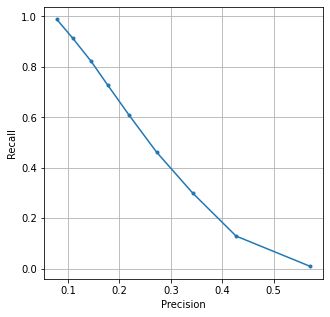

In [66]:
yhat = df_oot.nsl_v2_prob.values
y_true = df_oot.ns_flag.values
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

print('Data Size:',y_true.shape[0],' True DS NS:',sum(y_true))    
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)


In [103]:
# Only Non-SP
df_oot = df_oot2[df_oot2.business_type!='sole_proprietorship'].copy()

custom_bins = [0,0.1,0.2,0.3,0.4,0.45,0.5,0.6,0.7,0.8,0.9,1]
# custom_bins = [0,0.6,1]

df_oot['proba'] = np.round(df_oot['proba'], 3)
# df_oot['DecileRank']= pd.qcut(df_oot['proba'], q=5)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats['ltv'] = df_oot.groupby(by='DecileRank')['revenue_ltv'].sum()
df_stats['avg_ltv'] = df_stats['ltv'] / df_stats['volume']

df_stats

,ns_flag,volume,volume%,ltv,avg_ltv
DecileRank,,,,,
"(0.0, 0.1]",0.006299,10478,0.10,5.460778e+06,521.166107
"(0.1, 0.2]",0.019831,25516,0.25,1.480329e+07,580.157148
"(0.2, 0.3]",0.037960,17492,0.17,1.419564e+07,811.550301
"(0.3, 0.4]",0.064692,11547,0.11,9.908274e+06,858.082062
"(0.4, 0.45]",0.085667,5463,0.05,5.155258e+06,943.667940
"(0.45, 0.5]",0.103594,5425,0.05,6.296081e+06,1160.567977
"(0.5, 0.6]",0.137716,9614,0.10,1.214890e+07,1263.667439
"(0.6, 0.7]",0.201904,7459,0.07,1.352898e+07,1813.779709
"(0.7, 0.8]",0.300057,5249,0.05,1.316958e+07,2508.969951


In [92]:
# df_stats.to_csv(project_path+'rough.csv')

Data Size: 101186  True DS NS: 8665
threshold: 0.1  predicted: 90791  pred NS Rate: 0.897  precision: 0.095  recall: 0.992  auc: 0.552
threshold: 0.2  predicted: 65270  pred NS Rate: 0.645  precision: 0.124  recall: 0.934  auc: 0.658
threshold: 0.3  predicted: 47720  pred NS Rate: 0.472  precision: 0.156  recall: 0.858  auc: 0.711
threshold: 0.4  predicted: 36166  pred NS Rate: 0.357  precision: 0.185  recall: 0.772  auc: 0.727
threshold: 0.45  predicted: 30703  pred NS Rate: 0.303  precision: 0.203  recall: 0.718  auc: 0.726
threshold: 0.5  predicted: 25280  pred NS Rate: 0.25  precision: 0.224  recall: 0.653  auc: 0.721
threshold: 0.6  predicted: 15641  pred NS Rate: 0.155  precision: 0.277  recall: 0.5  auc: 0.689
threshold: 0.7  predicted: 8174  pred NS Rate: 0.081  precision: 0.346  recall: 0.326  auc: 0.634
threshold: 0.8  predicted: 2921  pred NS Rate: 0.029  precision: 0.429  recall: 0.145  auc: 0.563
threshold: 0.9  predicted: 147  pred NS Rate: 0.001  precision: 0.571  recall

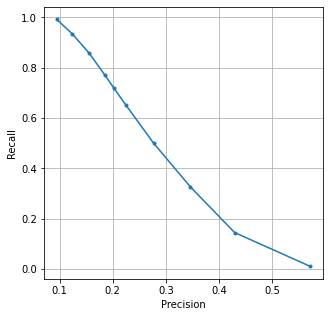

In [104]:
yhat = df_oot.nsl_v2_prob.values
y_true = df_oot.ns_flag.values
thresholds = [0.1,0.2,0.3,0.4,0.45, 0.5,0.6,0.7,0.8,0.9]

print('Data Size:',y_true.shape[0],' True DS NS:',sum(y_true))    
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)


In [94]:
# V1

custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# custom_bins = [0,0.2,0.4,0.6,0.8,1]

df_oot['pred_prob'] = np.round(df_oot['pred_prob'], 3)
# df_oot['DecileRank']= pd.qcut(df_oot['proba'], q=5)
df_oot['DecileRank_v1']= pd.cut(df_oot['pred_prob'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank_v1')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank_v1')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats['ltv'] = df_oot.groupby(by='DecileRank_v1')['revenue_ltv'].sum()
df_stats['avg_ltv'] = df_stats['ltv'] / df_stats['volume']

df_stats

,ns_flag,volume,volume%,ltv,avg_ltv
DecileRank_v1,,,,,
"(0.0, 0.1]",0.019352,24339,0.24,1.380083e+07,567.025237
"(0.1, 0.2]",0.036549,29659,0.29,2.238707e+07,754.815380
"(0.2, 0.3]",0.081338,12110,0.12,1.165844e+07,962.712160
"(0.3, 0.4]",0.118660,9700,0.10,1.306139e+07,1346.535060
"(0.4, 0.5]",0.143031,11529,0.11,1.642388e+07,1424.571001
"(0.5, 0.6]",0.216826,9224,0.09,1.712324e+07,1856.378645
"(0.6, 0.7]",0.257294,3016,0.03,5.863437e+06,1944.110456
"(0.7, 0.8]",0.341206,1609,0.02,4.277215e+06,2658.306691
"(0.8, 0.9]",NaN,0,0.00,0.000000e+00,NaN


In [95]:
# df_stats.to_csv(project_path+'rough.csv')

Data Size: 101186  True DS NS: 8665
threshold: 0.1  predicted: 76847  pred NS Rate: 0.759  precision: 0.107  recall: 0.946  auc: 0.602
threshold: 0.2  predicted: 47188  pred NS Rate: 0.466  precision: 0.151  recall: 0.821  auc: 0.694
threshold: 0.3  predicted: 35078  pred NS Rate: 0.347  precision: 0.175  recall: 0.707  auc: 0.697
threshold: 0.4  predicted: 25378  pred NS Rate: 0.251  precision: 0.196  recall: 0.574  auc: 0.677
threshold: 0.5  predicted: 13849  pred NS Rate: 0.137  precision: 0.24  recall: 0.384  auc: 0.635
threshold: 0.6  predicted: 4625  pred NS Rate: 0.046  precision: 0.286  recall: 0.153  auc: 0.559
threshold: 0.7  predicted: 1609  pred NS Rate: 0.016  precision: 0.341  recall: 0.063  auc: 0.526
threshold: 0.8  predicted: 0  pred NS Rate: 0.0  precision: 0.0  recall: 0.0  auc: 0.5
threshold: 0.9  predicted: 0  pred NS Rate: 0.0  precision: 0.0  recall: 0.0  auc: 0.5


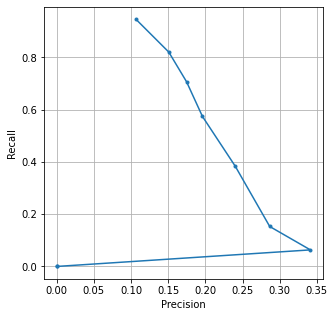

In [96]:
yhat = df_oot.pred_prob.values
y_true = df_oot.ns_flag.values
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

print('Data Size:',y_true.shape[0],' True DS NS:',sum(y_true))    
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)


In [97]:
# Only SP
df_oot = df_oot2[df_oot2.business_type=='sole_proprietorship'].copy()

custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# custom_bins = [0,0.2,0.4,0.6,0.8,1]

df_oot['proba'] = np.round(df_oot['proba'], 3)
# df_oot['DecileRank']= pd.qcut(df_oot['proba'], q=5)
df_oot['DecileRank']= pd.cut(df_oot['proba'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats['ltv'] = df_oot.groupby(by='DecileRank')['revenue_ltv'].sum()
df_stats['avg_ltv'] = df_stats['ltv'] / df_stats['volume']

df_stats

,ns_flag,volume,volume%,ltv,avg_ltv
DecileRank,,,,,
"(0.0, 0.1]",0.003865,12159,0.26,5.852491e+06,481.329942
"(0.1, 0.2]",0.014250,17404,0.37,8.034314e+06,461.636044
"(0.2, 0.3]",0.026298,8784,0.19,4.395885e+06,500.442304
"(0.3, 0.4]",0.047907,4300,0.09,2.480356e+06,576.826973
"(0.4, 0.5]",0.067698,2068,0.04,1.559843e+06,754.275970
"(0.5, 0.6]",0.110455,1186,0.03,1.139583e+06,960.862383
"(0.6, 0.7]",0.159501,721,0.02,7.893839e+05,1094.845867
"(0.7, 0.8]",0.278351,388,0.01,7.344966e+05,1893.032572
"(0.8, 0.9]",0.346667,75,0.00,1.562640e+05,2083.520636


In [99]:
# df_stats.to_csv(project_path+'rough.csv')

Data Size: 47103  True DS NS: 1252
threshold: 0.1  predicted: 35019  pred NS Rate: 0.743  precision: 0.034  recall: 0.962  auc: 0.612
threshold: 0.2  predicted: 17593  pred NS Rate: 0.374  precision: 0.055  recall: 0.767  auc: 0.702
threshold: 0.3  predicted: 8770  pred NS Rate: 0.186  precision: 0.083  recall: 0.584  auc: 0.704
threshold: 0.4  predicted: 4453  pred NS Rate: 0.095  precision: 0.117  recall: 0.415  auc: 0.665
threshold: 0.5  predicted: 2379  pred NS Rate: 0.051  precision: 0.16  recall: 0.304  auc: 0.63
threshold: 0.6  predicted: 1190  pred NS Rate: 0.025  precision: 0.211  recall: 0.2  auc: 0.59
threshold: 0.7  predicted: 466  pred NS Rate: 0.01  precision: 0.29  recall: 0.108  auc: 0.55
threshold: 0.8  predicted: 78  pred NS Rate: 0.002  precision: 0.346  recall: 0.022  auc: 0.51
threshold: 0.9  predicted: 0  pred NS Rate: 0.0  precision: 0.0  recall: 0.0  auc: 0.5


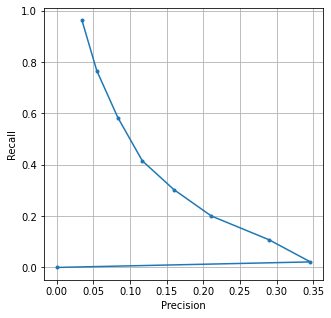

In [98]:
yhat = df_oot.nsl_v2_prob.values
y_true = df_oot.ns_flag.values
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

print('Data Size:',y_true.shape[0],' True DS NS:',sum(y_true))    
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)


In [100]:
# V1

custom_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# custom_bins = [0,0.2,0.4,0.6,0.8,1]

df_oot['pred_prob'] = np.round(df_oot['pred_prob'], 3)
# df_oot['DecileRank']= pd.qcut(df_oot['proba'], q=5)
df_oot['DecileRank_v1']= pd.cut(df_oot['pred_prob'], bins=custom_bins)
df_stats = pd.DataFrame(df_oot.groupby(by='DecileRank_v1')['ns_flag'].mean())
df_stats['volume'] = df_oot.groupby(by='DecileRank_v1')['ns_flag'].count()
df_stats['volume%'] = np.round((df_stats['volume'] / df_stats['volume'].sum()), 2)
df_stats['ltv'] = df_oot.groupby(by='DecileRank_v1')['revenue_ltv'].sum()
df_stats['avg_ltv'] = df_stats['ltv'] / df_stats['volume']

df_stats

,ns_flag,volume,volume%,ltv,avg_ltv
DecileRank_v1,,,,,
"(0.0, 0.1]",0.008626,20752,0.44,9.259790e+06,446.211955
"(0.1, 0.2]",0.020149,9380,0.20,4.916969e+06,524.197095
"(0.2, 0.3]",0.034087,6454,0.14,3.810204e+06,590.363114
"(0.3, 0.4]",0.045884,6669,0.14,3.947639e+06,591.938721
"(0.4, 0.5]",0.064000,2375,0.05,1.563331e+06,658.244829
"(0.5, 0.6]",0.127435,1232,0.03,1.355331e+06,1100.106673
"(0.6, 0.7]",0.137097,124,0.00,1.473845e+05,1188.584556
"(0.7, 0.8]",0.273504,117,0.00,1.472192e+05,1258.283741
"(0.8, 0.9]",NaN,0,0.00,0.000000e+00,NaN


In [101]:
# df_stats.to_csv(project_path+'rough.csv')

Data Size: 47103  True DS NS: 1252
threshold: 0.1  predicted: 26351  pred NS Rate: 0.559  precision: 0.041  recall: 0.857  auc: 0.653
threshold: 0.2  predicted: 16971  pred NS Rate: 0.36  precision: 0.052  recall: 0.706  auc: 0.678
threshold: 0.3  predicted: 10517  pred NS Rate: 0.223  precision: 0.063  recall: 0.53  auc: 0.658
threshold: 0.4  predicted: 3848  pred NS Rate: 0.082  precision: 0.093  recall: 0.286  auc: 0.605
threshold: 0.5  predicted: 1473  pred NS Rate: 0.031  precision: 0.14  recall: 0.165  auc: 0.568
threshold: 0.6  predicted: 241  pred NS Rate: 0.005  precision: 0.203  recall: 0.039  auc: 0.517
threshold: 0.7  predicted: 117  pred NS Rate: 0.002  precision: 0.274  recall: 0.026  auc: 0.512
threshold: 0.8  predicted: 0  pred NS Rate: 0.0  precision: 0.0  recall: 0.0  auc: 0.5
threshold: 0.9  predicted: 0  pred NS Rate: 0.0  precision: 0.0  recall: 0.0  auc: 0.5


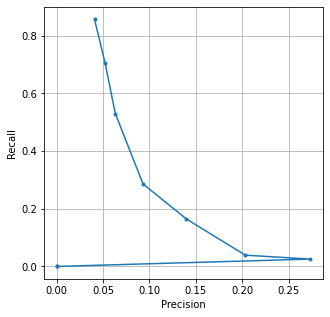

In [102]:
yhat = df_oot.pred_prob.values
y_true = df_oot.ns_flag.values
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

print('Data Size:',y_true.shape[0],' True DS NS:',sum(y_true))    
precision_recall_threshold_plot(y_true=y_true, yhat=yhat, thresholds=thresholds)
